# ML notebook for Project 20 group

## Students

- Sushil Dudani
- Tirthajyoti Sarkar
- Vivek Sathe

## Description

Typical office material supply company running their operations sees many challenges, one of the major ones being how to measure the effectiveness of sales and marketing operations. We have picked up an imaginary office material supply company “Office Corp.” for our analysis. They have tested a telemarketing campaign targeting existing domestic business customers with a random selection of products. For this exercise, a sample of 16,172 customers were targeted. The products being marketed are Desk, Executive Chair, Standard Chair, Monitor, Printer Computer, Insurance, Toner and Office Supplies.  

Office Corp would like to leverage the knowledge gained from this survey (and associated dataset) for future campaigns. Office Corp has hired an analyst team to solve the following three problems using various analytical techniques.  

- Profile the customers that responded to the campaign to understand the characteristics of customers who made purchases. 

- Develop models using the campaign results to target responsive, profitable customers for future campaigns. 

- Summarize and categorize the profitability of the various marketing segments which may be used to optimize future campaigns.

---

## Scientific questions/investigation

Given marketing dataset, there are three key problems to solve.  

- Given campaign period data, looking at customer profile, we aim to predict whether customer will Buy or Not Buy. We intent to frame this as a Classification problem. 

- Among the customers who are predicted as they will buy, we aim to estimate what will be size of purchase. We intent to frame this as a Regression problem. 

- For those customers who are likely to purchase and in general other customers using their historical product purchase data, we aim to predict top 3 products that are likely to be purchased. Also try to predict whether there are any product bundles Office Corp may sell more, etc. We intend to frame this as a Clustering problem.  

In the process of analysis, we intent to carry out,  

- data missing and imputation treatments,  

- data sufficiency and randomized splitting for test-train sets,  

- test amount of data necessary for optimal predictions & accuracy, etc.  

This last topic of determining optimal amount of data is called the ‘sample complexity study’ and it is extremely important for such real-life marketing campaign problems because collecting too much data unnecessarily may cause the company cost overrun. Data scientists should be able to advise the business department on how much data to collect to achieve a decent model performance. 

---

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib as mpl
mpl.rcParams['figure.dpi']=125

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Load (cleaned and formatted) dataset

In [2]:
df = pd.read_csv("AddedFeatures_campaign_sale.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12132 entries, 0 to 12131
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Index                              12132 non-null  int64  
 1   Campaign Period Sales              12132 non-null  float64
 2   Buy                                12132 non-null  int64  
 3   Historical Sales Volume            12132 non-null  float64
 4   Number of Prior Year Transactions  12132 non-null  int64  
 5   Number of Transactions             12132 non-null  int64  
 6   Purchase Breadth                   12132 non-null  int64  
 7   Customer_engagement_days           12132 non-null  int64  
 8   Days_since_last_transaction        12132 non-null  int64  
 9   Customer_engagement_length         12132 non-null  object 
 10  Language_group                     12132 non-null  object 
 11  Repurchase Method                  12132 non-null  obj

In [4]:
df.drop(['Index'],axis=1,inplace=True)

In [5]:
df.columns

Index(['Campaign Period Sales', 'Buy', 'Historical Sales Volume',
       'Number of Prior Year Transactions', 'Number of Transactions',
       'Purchase Breadth', 'Customer_engagement_days',
       'Days_since_last_transaction', 'Customer_engagement_length',
       'Language_group', 'Repurchase Method', 'Last Transaction Channel',
       'Number of Employees', 'Service Level', 'Do No Disturb',
       'Email Available', 'Desk', 'Executive Chair', 'Standard Chair',
       'Monitor', 'Printer', 'Computer', 'Insurance', 'Toner',
       'Office Supplies'],
      dtype='object')

In [6]:
cat_vars = ['Customer_engagement_length',
       'Language_group', 'Repurchase Method', 'Last Transaction Channel',
       'Number of Employees', 'Service Level', 'Do No Disturb',
       'Email Available', 'Desk', 'Executive Chair', 'Standard Chair',
       'Monitor', 'Printer', 'Computer', 'Insurance', 'Toner',
       'Office Supplies']

In [7]:
d=pd.get_dummies(df,columns=cat_vars)

In [8]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12132 entries, 0 to 12131
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Campaign Period Sales                    12132 non-null  float64
 1   Buy                                      12132 non-null  int64  
 2   Historical Sales Volume                  12132 non-null  float64
 3   Number of Prior Year Transactions        12132 non-null  int64  
 4   Number of Transactions                   12132 non-null  int64  
 5   Purchase Breadth                         12132 non-null  int64  
 6   Customer_engagement_days                 12132 non-null  int64  
 7   Days_since_last_transaction              12132 non-null  int64  
 8   Customer_engagement_length_Long-term     12132 non-null  uint8  
 9   Customer_engagement_length_Mid-term      12132 non-null  uint8  
 10  Customer_engagement_length_Short-term    12132

## Classification

In [9]:
names = ["Logistic Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Bagging",
         "Naive Bayes", "QDA"]

### List of classifier (Scikit-learn estimator objects with hyperparamemetr settings)

In [10]:
classifiers = [
    LogisticRegression(C=0.1,n_jobs=-1),
    KNeighborsClassifier(10,n_jobs=-1),
    SVC(kernel="linear", C=0.1),
    SVC(gamma='scale', C=1),
    DecisionTreeClassifier(max_depth=10,min_samples_leaf=10),
    RandomForestClassifier(max_depth=3, n_estimators=50, 
                           max_features=5,min_samples_leaf=10,n_jobs=-1),
    MLPClassifier(hidden_layer_sizes=(100,100),alpha=0.2, 
                  max_iter=200,learning_rate_init=0.01,learning_rate='adaptive',
                 early_stopping=True,validation_fraction=0.2),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                       n_estimators=50,learning_rate=0.1),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                       n_estimators=50, max_features=5,n_jobs=-1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.1)]

### Test/train set

In [11]:
X = d.drop(['Campaign Period Sales','Buy'],axis=1)
y = d['Buy']

In [12]:
TEST_FRAC = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_FRAC, 
                                                    random_state=7406)

In [13]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

### Running through the classifiers once

In [14]:
for name, clf in zip(names, classifiers):
    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    delta_t = round((t2-t1)*1000,3)
    score = round(clf.score(X_test, y_test),3)
    print(f"Fitting with {name} took {delta_t} ms.\n Score: {score}")
    print("-"*75)

Fitting with Logistic Regression took 1261.333 ms.
 Score: 0.802
---------------------------------------------------------------------------
Fitting with Nearest Neighbors took 252.038 ms.
 Score: 0.786
---------------------------------------------------------------------------
Fitting with Linear SVM took 2061.83 ms.
 Score: 0.801
---------------------------------------------------------------------------
Fitting with RBF SVM took 5654.016 ms.
 Score: 0.8
---------------------------------------------------------------------------
Fitting with Decision Tree took 44.828 ms.
 Score: 0.82
---------------------------------------------------------------------------
Fitting with Random Forest took 133.506 ms.
 Score: 0.802
---------------------------------------------------------------------------
Fitting with Neural Net took 2258.361 ms.
 Score: 0.802
---------------------------------------------------------------------------
Fitting with AdaBoost took 1068.22 ms.
 Score: 0.836
------------

### Function to run through classifiers repeatedly

In [15]:
def run_classifiers(clf_lst,names=None,num_runs=10, verbose=0):
    """
    Runs the list of classifiers for a fixed number of times
    """
    if names is None:
        names = [str(type(c)).split('.')[-1][:-2] for c in clf_lst]
    scores = dict.fromkeys(names,[])
    f1_scores = dict.fromkeys(names,[])
    runtimes = dict.fromkeys(names,[])
    for name, clf in zip(names, clf_lst):
        sc,f1,rt= [],[],[]
        for i in range(num_runs):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC,)
            X_train = StandardScaler().fit_transform(X_train)
            X_test = StandardScaler().fit_transform(X_test)
            t1 = time.time()
            clf.fit(X_train, y_train)
            t2 = time.time()
            delta_t = round((t2-t1)*1000,3)
            score = round(clf.score(X_test, y_test),3)
            f1score = f1_score(y_test,clf.predict(X_test))
            sc.append(score)
            f1.append(f1score)
            rt.append(delta_t)
        sc = np.array(sc)
        f1 = np.array(f1)
        rt = np.array(rt)
        scores[name] = sc
        f1_scores[name] = f1
        runtimes[name] = rt
        if verbose:
            print(f"Finished {num_runs} runs for {name} algorithm")
            print("-"*75)
    # Convert to DataFrame
    df_scores = pd.DataFrame(scores)
    df_f1scores = pd.DataFrame(f1_scores)
    df_runtimes = pd.DataFrame(runtimes)
    
    return df_scores, df_f1scores,df_runtimes

### Run through clasifiers and plot

In [16]:
d1,d2,d3 = run_classifiers(clf_lst=classifiers,
                           names=names,
                           num_runs=25,
                           verbose=1)

Finished 25 runs for Logistic Regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Nearest Neighbors algorithm
---------------------------------------------------------------------------
Finished 25 runs for Linear SVM algorithm
---------------------------------------------------------------------------
Finished 25 runs for RBF SVM algorithm
---------------------------------------------------------------------------
Finished 25 runs for Decision Tree algorithm
---------------------------------------------------------------------------
Finished 25 runs for Random Forest algorithm
---------------------------------------------------------------------------
Finished 25 runs for Neural Net algorithm
---------------------------------------------------------------------------
Finished 25 runs for AdaBoost algorithm
---------------------------------------------------------------------------
Finished 25 runs for Bagging algorithm


In [17]:
d1

,Logistic Regression,Nearest Neighbors,Linear SVM,RBF SVM,Decision Tree,Random Forest,Neural Net,AdaBoost,Bagging,Naive Bayes,QDA
0,0.805,0.796,0.788,0.805,0.824,0.809,0.808,0.833,0.730,0.778,0.810
1,0.817,0.789,0.811,0.813,0.836,0.800,0.813,0.853,0.742,0.795,0.803
2,0.816,0.795,0.801,0.806,0.821,0.792,0.809,0.845,0.735,0.794,0.797
3,0.805,0.806,0.803,0.809,0.859,0.772,0.804,0.849,0.735,0.789,0.783
4,0.804,0.793,0.803,0.820,0.851,0.808,0.801,0.839,0.737,0.804,0.788
5,0.818,0.793,0.803,0.806,0.835,0.792,0.805,0.861,0.735,0.806,0.791
6,0.814,0.791,0.810,0.815,0.827,0.794,0.805,0.852,0.720,0.778,0.796
7,0.801,0.797,0.799,0.802,0.857,0.803,0.805,0.844,0.743,0.808,0.799
8,0.802,0.788,0.812,0.817,0.809,0.789,0.805,0.857,0.733,0.802,0.801
9,0.807,0.778,0.808,0.796,0.831,0.800,0.804,0.849,0.730,0.788,0.800


In [18]:
def plot_bars(d,
              t1="Mean accuracy score of algorithms",
              t2="Std.dev of the accuracy scores of algorithms"):
    """
    """
    fig,ax=plt.subplots(1,2,figsize=(14,5))
    ax[0].barh(y=list(d.columns),width=d.describe().T['mean'],height=0.6,color='goldenrod')
    ax[0].set_title(t1)
    ax[1].barh(y=list(d.columns),width=d.describe().T['std'],height=0.6,color='dodgerblue')
    ax[1].set_title(t2)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_color('#DDDDDD')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].spines['bottom'].set_color('#DDDDDD')
    plt.tight_layout(pad=1.5)
    plt.show()

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize']=13
mpl.rcParams['ytick.labelsize']=13
mpl.rcParams['figure.dpi']=125
mpl.rcParams['axes.titlesize']=18

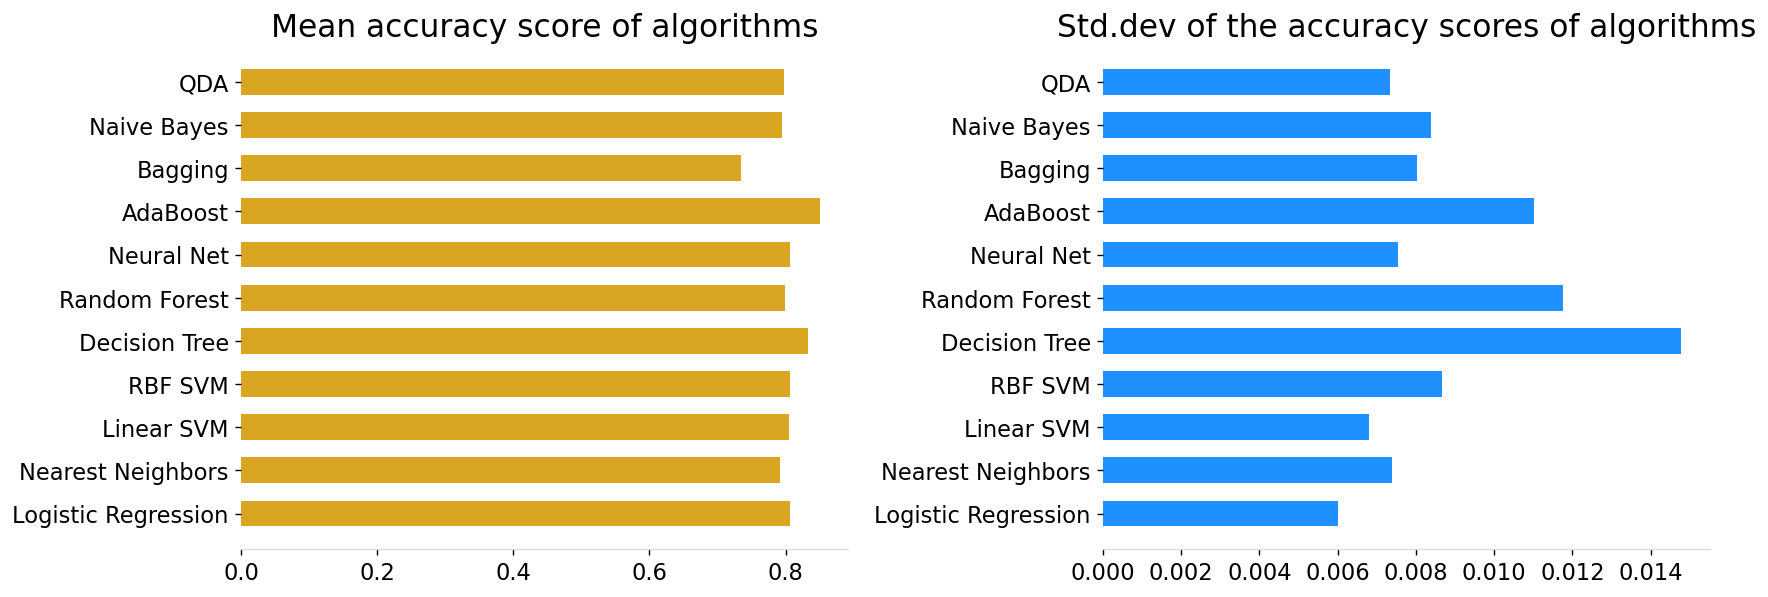

In [20]:
plot_bars(d1,
          t1="Mean accuracy score of algorithms",
          t2="Std.dev of the accuracy scores of algorithms")

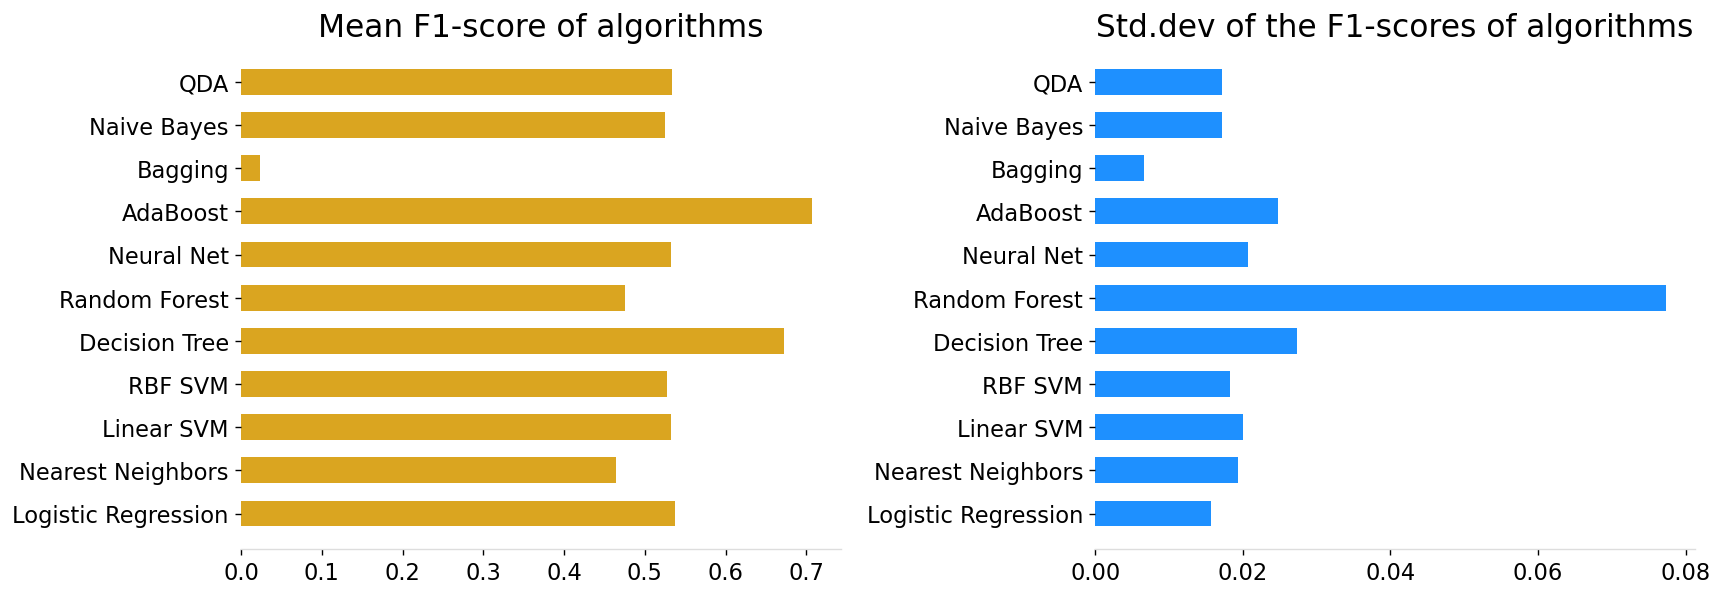

In [21]:
plot_bars(d2,
          t1="Mean F1-score of algorithms",
          t2="Std.dev of the F1-scores of algorithms")

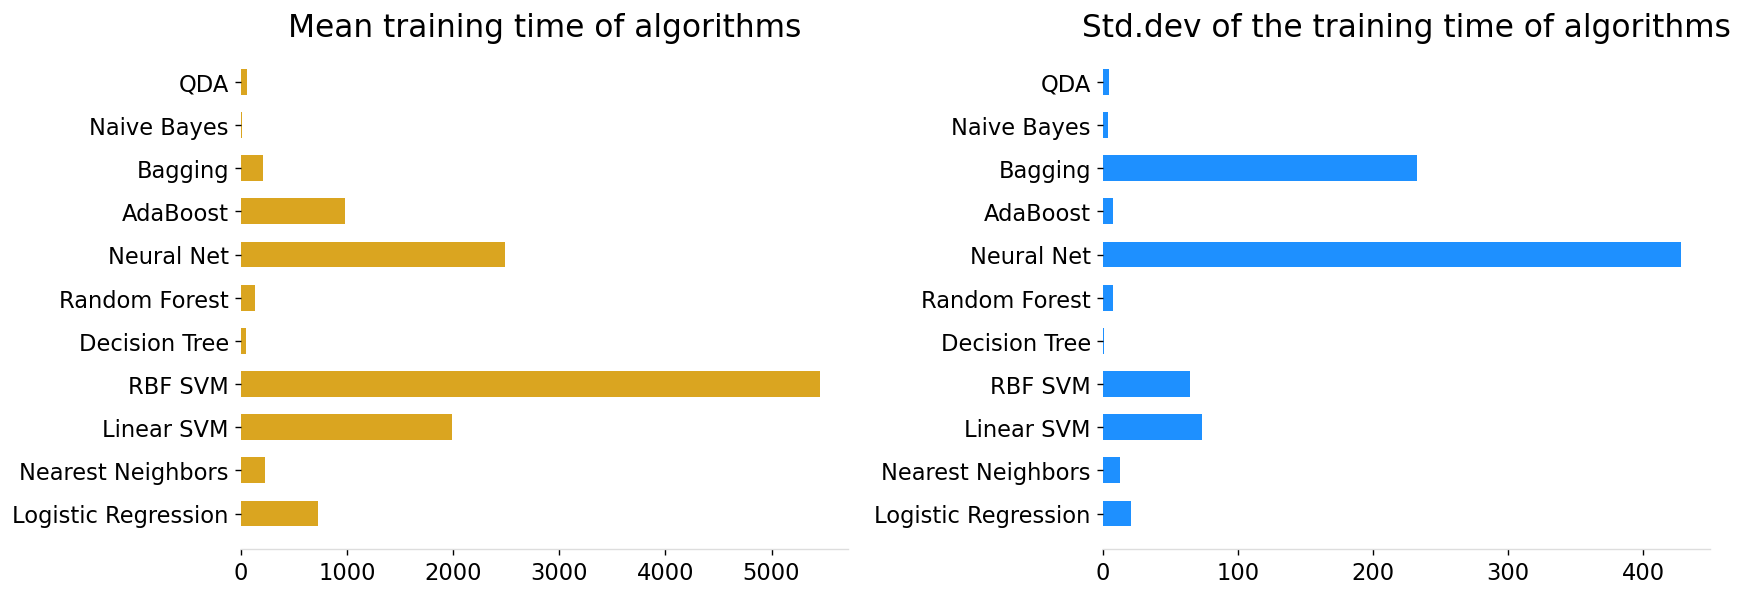

In [22]:
plot_bars(d3,
          t1="Mean training time of algorithms",
          t2="Std.dev of the training time of algorithms")

## Grid search of `AdaBoost`

In [23]:
from sklearn.model_selection import GridSearchCV
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}
clf = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1)

In [24]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 14.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1

In [25]:
boost_grid=pd.DataFrame(clf.cv_results_['params'])

In [26]:
boost_grid['F1-score']=clf.cv_results_['mean_test_score']

In [27]:
boost_grid

,base_estimator__max_depth,base_estimator__min_samples_leaf,learning_rate,n_estimators,F1-score
0,2,5,0.01,10,0.539551
1,2,5,0.01,50,0.539191
2,2,5,0.01,250,0.729609
3,2,5,0.01,1000,0.732196
4,2,5,0.10,10,0.535068
...,...,...,...,...,...
75,10,10,0.01,1000,0.676300
76,10,10,0.10,10,0.697648
77,10,10,0.10,50,0.666566
78,10,10,0.10,250,0.674494


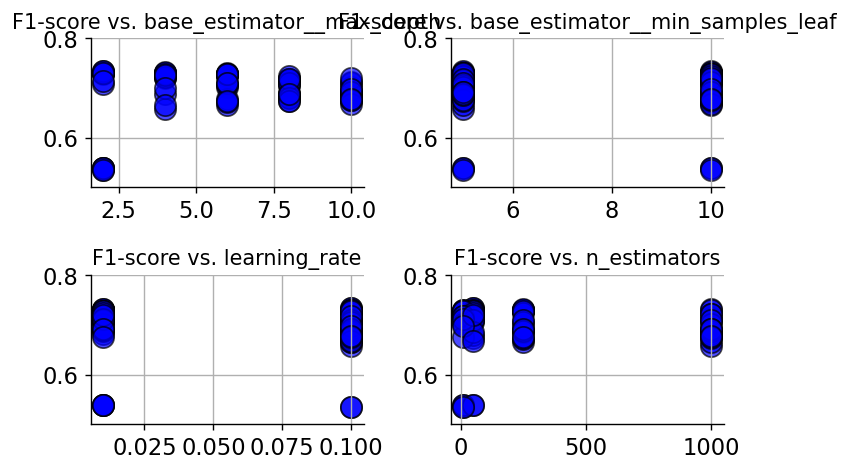

In [28]:
fig, ax = plt.subplots(2,2,figsize=(6,4))
ax= ax.ravel()
for i,c in enumerate(boost_grid.columns[:-1]):
    ax[i].scatter(boost_grid[c],boost_grid['F1-score'],
                 c='blue',edgecolor='k',alpha=0.7,s=150,
                 )
    ax[i].set_title(f"F1-score vs. {c}",fontsize=12)
    ax[i].set_ylim(0.5,0.8)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(True)
plt.tight_layout(pad=1.5)
plt.show()

## Regression

In [29]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### List of regressors (Scikit-learn estimator objects with hyperparamemetr settings)

In [30]:
reg_names = ["Linear regression","L1 (LASSO) regression","Ridge regression",
            "Support vector regression","Decision tree regression",
            "Random forest regression","Neural network regression"]

In [31]:
regressors = [LinearRegression(n_jobs=-1),
              Lasso(alpha=0.1),
              Ridge(alpha=0.1),
              SVR(kernel='poly',degree=3),
              DecisionTreeRegressor(max_depth=10,min_samples_leaf=10),
              RandomForestRegressor(max_depth=3, n_estimators=50, 
                           max_features=5,min_samples_leaf=10,n_jobs=-1),
              MLPRegressor(hidden_layer_sizes=(100,100),alpha=0.2, 
                  max_iter=200,learning_rate_init=0.01,learning_rate='adaptive',
                 early_stopping=True,validation_fraction=0.2)]

### Regression data and test/train split

In [32]:
d_reg= d[d['Campaign Period Sales']>0.0]

In [33]:
X = d_reg.drop(['Campaign Period Sales','Buy'],axis=1)
y = d_reg['Campaign Period Sales']

### Function to run through classifiers repeatedly

In [34]:
def run_regressors(reg_lst,names=None,num_runs=10, verbose=0):
    """
    Runs the list of regressors for a fixed number of times
    """
    if names is None:
        names = [str(type(c)).split('.')[-1][:-2] for c in reg_lst]
    scores = dict.fromkeys(names,[])
    runtimes = dict.fromkeys(names,[])
    for name, reg in zip(names, reg_lst):
        sc,rt= [],[]
        for i in range(num_runs):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC,)
            X_train = StandardScaler().fit_transform(X_train)
            X_test = StandardScaler().fit_transform(X_test)
            t1 = time.time()
            reg.fit(X_train, y_train)
            t2 = time.time()
            delta_t = round((t2-t1)*1000,3)
            rmse = round(np.sqrt(np.mean((reg.predict(X_test)-y_test)**2).mean()),3)
            sc.append(rmse)
            rt.append(delta_t)
        sc = np.array(sc)
        rt = np.array(rt)
        scores[name] = sc
        runtimes[name] = rt
        if verbose:
            print(f"Finished {num_runs} runs for {name} algorithm")
            print("-"*75)
    # Convert to DataFrame
    df_scores = pd.DataFrame(scores)
    df_runtimes = pd.DataFrame(runtimes)
    
    return df_scores,df_runtimes

### Run through regressors and plot

In [35]:
d1_reg, d2_reg = run_regressors(reg_lst=regressors,names=reg_names,num_runs=25,verbose=1)

Finished 25 runs for Linear regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for L1 (LASSO) regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Ridge regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Support vector regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Decision tree regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Random forest regression algorithm
---------------------------------------------------------------------------
Finished 25 runs for Neural network regression algorithm
---------------------------------------------------------------------------


In [36]:
d1_reg

,Linear regression,L1 (LASSO) regression,Ridge regression,Support vector regression,Decision tree regression,Random forest regression,Neural network regression
0,1.303650e+13,136.627,221.055,359.106,105.435,243.665,115.737
1,1.812293e+12,153.591,159.536,343.913,96.573,404.997,107.710
2,6.978870e+13,186.164,124.995,354.722,100.029,244.459,96.170
3,1.390481e+12,170.425,105.668,321.071,144.556,272.324,141.531
4,4.317558e+13,208.800,137.068,347.963,146.503,340.249,108.262
5,5.046074e+12,148.906,183.603,349.109,141.939,301.997,132.723
6,4.847091e+11,136.190,124.645,394.469,156.305,315.882,141.805
7,3.340995e+13,104.545,117.895,373.906,138.679,292.459,131.335
8,6.636151e+12,183.289,129.261,278.875,149.214,269.681,126.970
9,1.110553e+14,144.900,128.492,284.049,111.820,265.870,148.340


In [37]:
d1_reg1 = d1_reg.drop(['Linear regression'],axis=1)

In [38]:
d1_reg1['Neural network regression'].mean()

123.22044

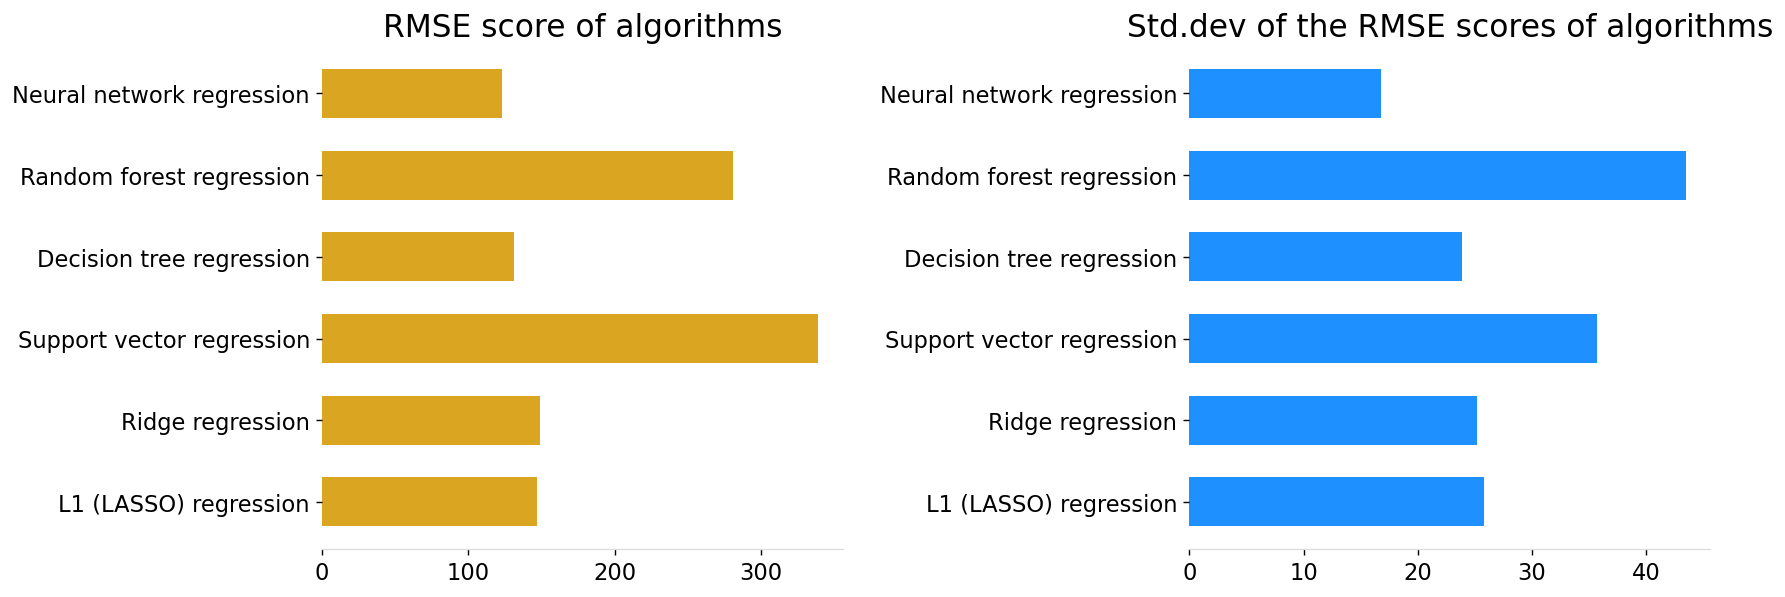

In [39]:
plot_bars(d1_reg1,
          t1="RMSE score of algorithms",
          t2="Std.dev of the RMSE scores of algorithms")

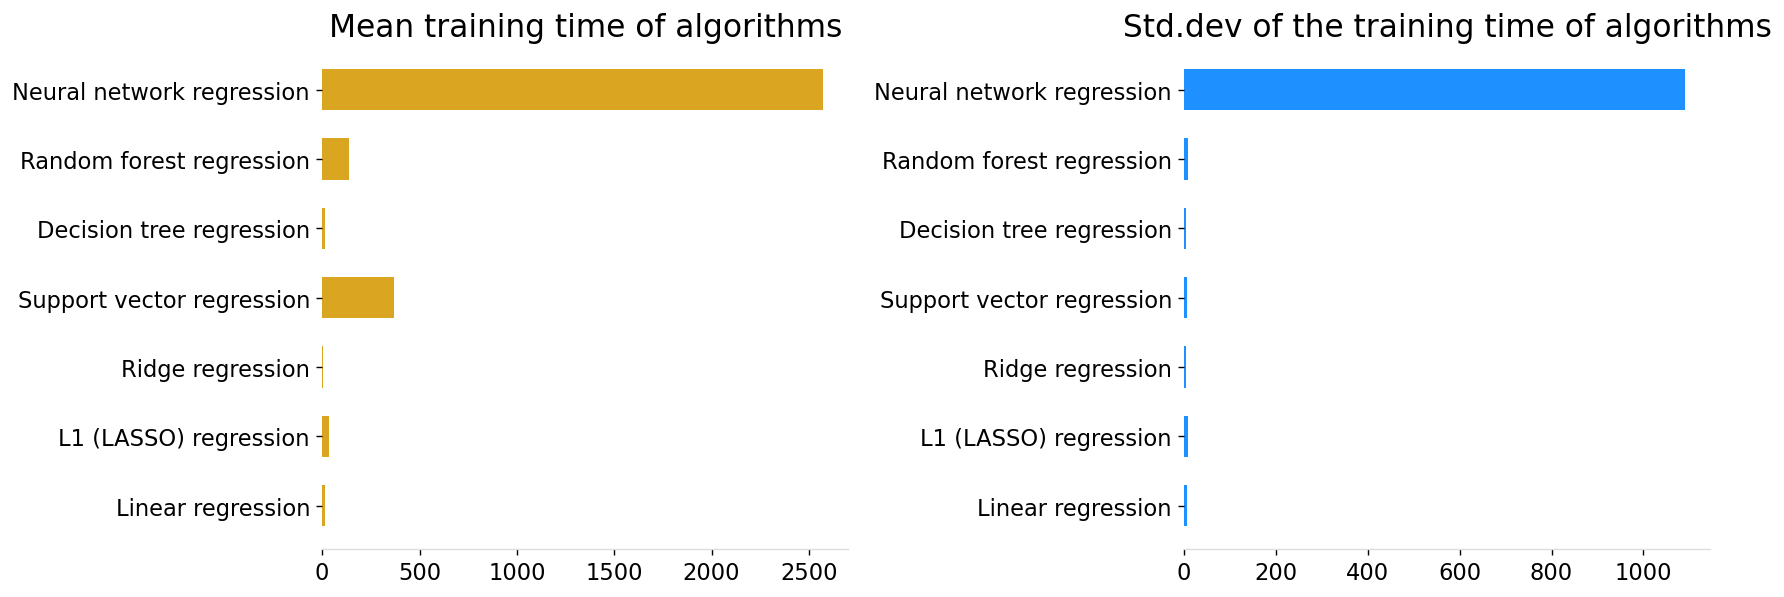

In [40]:
plot_bars(d2_reg,
          t1="Mean training time of algorithms",
          t2="Std.dev of the training time of algorithms")

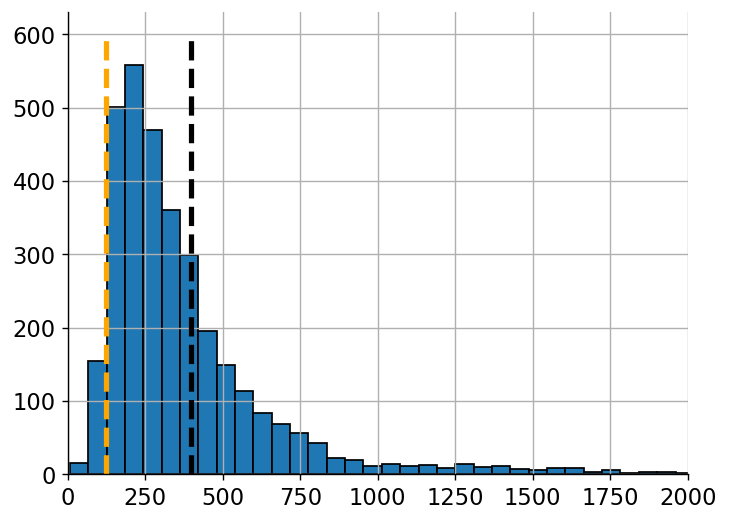

In [41]:
fig, ax = plt.subplots()
plt.hist(y,bins=100,edgecolor='k')
plt.xlim(0,2000)
plt.vlines(x=398,ymin=0,ymax=600,color='k',linestyle='--',linewidth=3)
plt.vlines(x=d1_reg1['Neural network regression'].mean(),
           ymin=0,ymax=600,color='orange',linestyle='--',linewidth=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True)
plt.show()

### Regression prediction and ground truth match plot

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC,)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
nn_reg = MLPRegressor(hidden_layer_sizes=(100,100),alpha=0.2, 
                  max_iter=200,learning_rate_init=0.01,learning_rate='adaptive',
                 early_stopping=True,validation_fraction=0.2)
nn_reg.fit(X_train,y_train)
preds = nn_reg.predict(X_test)

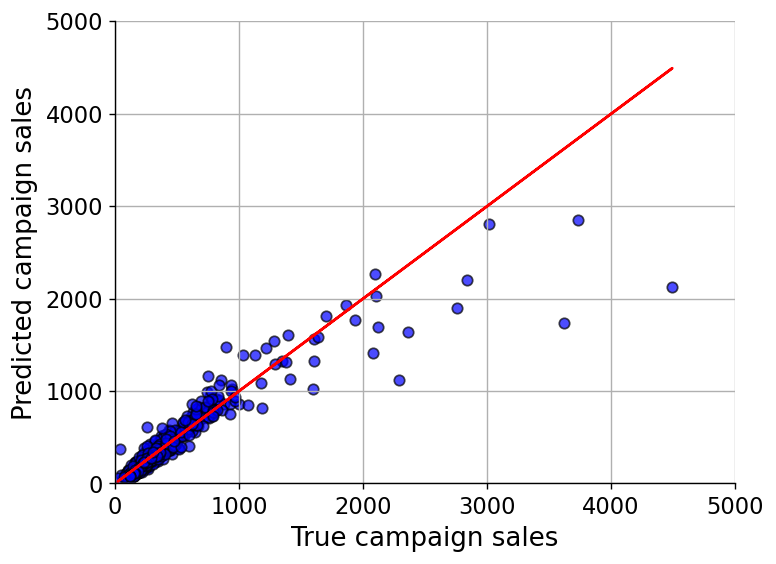

In [43]:
fig, ax = plt.subplots()
plt.scatter(x=y_test,y=preds,edgecolor='k',alpha=0.7,c='blue')
plt.plot(y_test,y_test,c='red')
plt.xlim(0,5000)
plt.ylim(0,5000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True)
plt.xlabel("True campaign sales",fontsize=15)
plt.ylabel("Predicted campaign sales",fontsize=15)
plt.show()

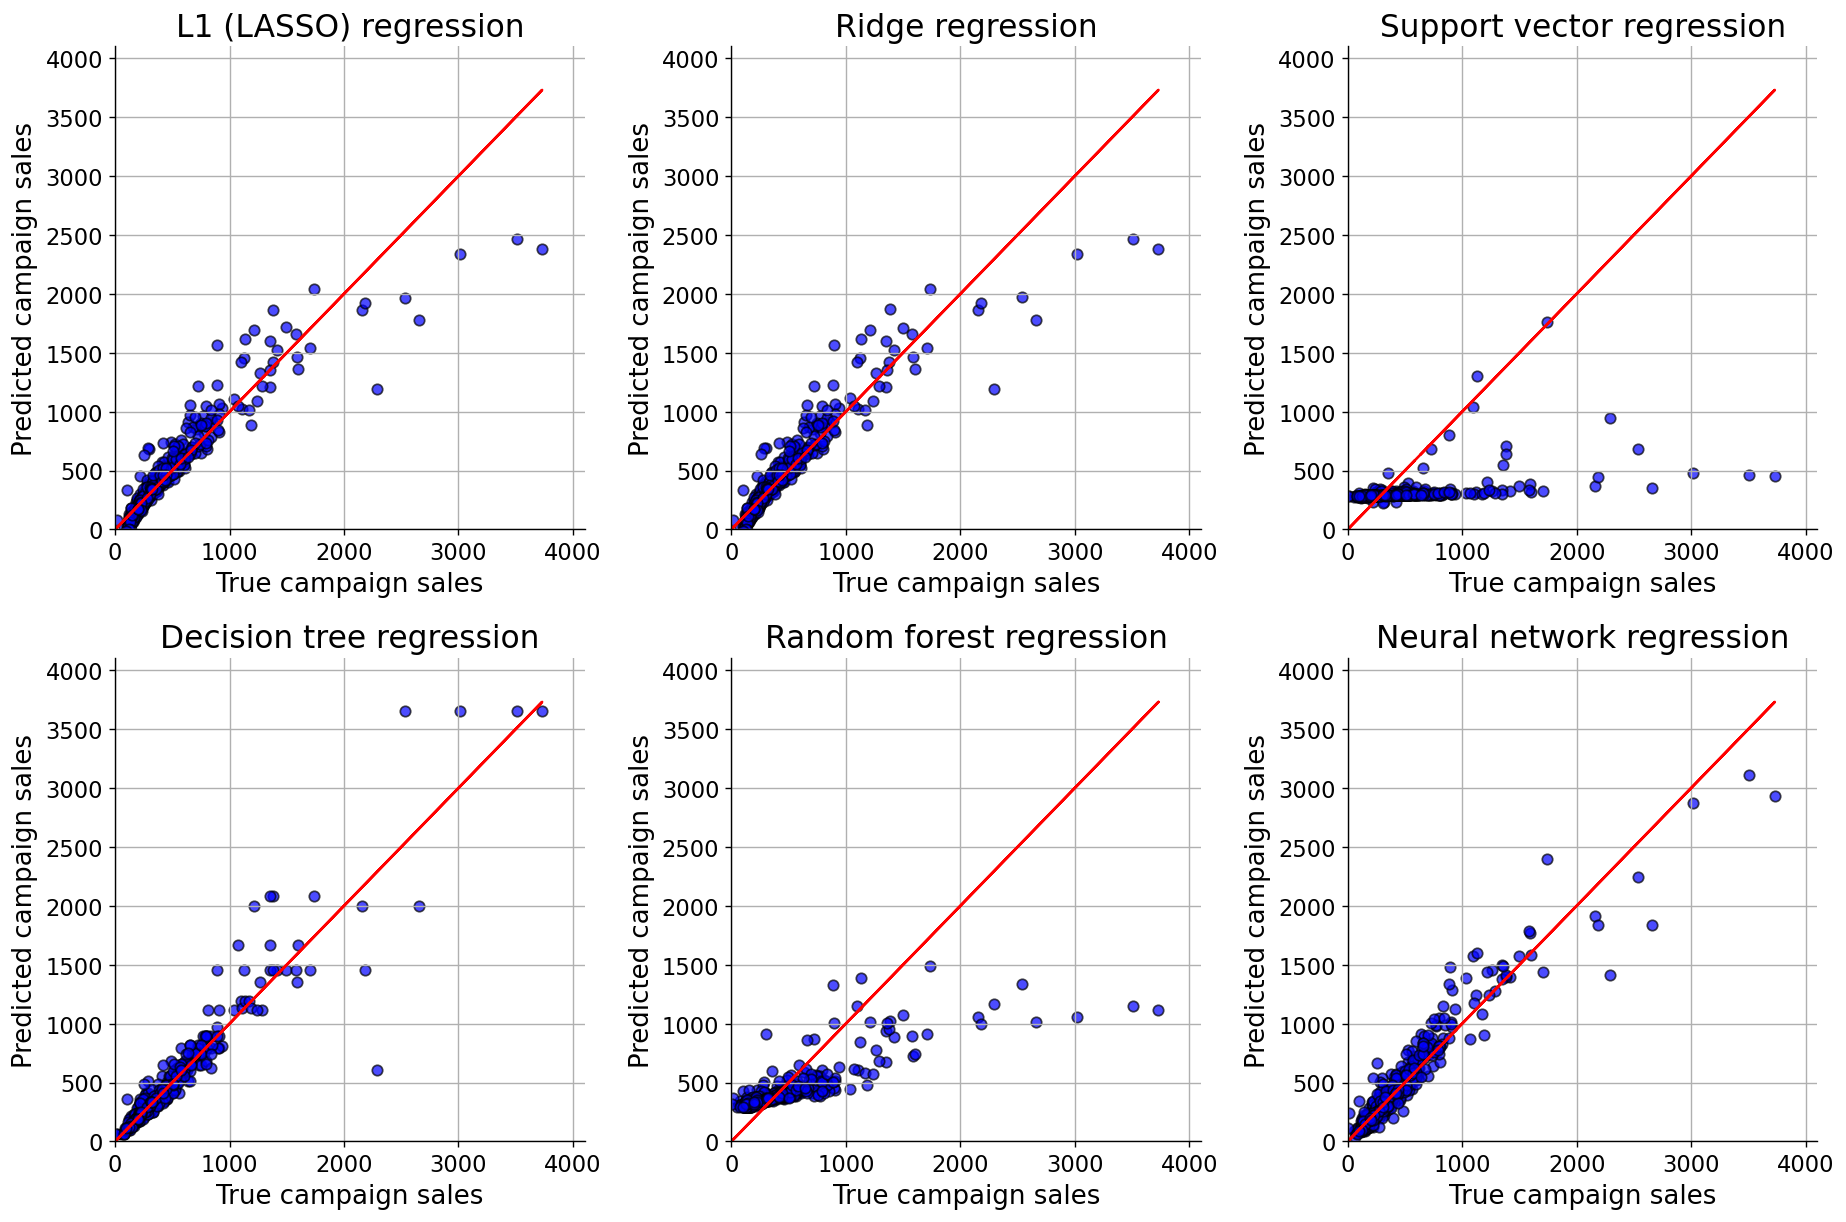

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC,)
xlim = y_test.max()
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

fig, ax = plt.subplots(2,3,figsize=(15,10))
ax= ax.ravel()
for i in range(6):
    reg = regressors[1:][i]
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    ax[i].scatter(x=y_test,y=preds,edgecolor='k',alpha=0.7,c='blue')
    ax[i].plot(y_test,y_test,c='red')
    ax[i].set_xlim(0,xlim*1.1)
    ax[i].set_ylim(0,xlim*1.1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].grid(True)
    ax[i].set_xlabel("True campaign sales",fontsize=15)
    ax[i].set_ylabel("Predicted campaign sales",fontsize=15)
    ax[i].set_title(reg_names[1:][i])
plt.tight_layout(pad=1.5)
plt.show()

## NN model tuning for regression

In [45]:
no_neurons = [i*10 for i in range(1,11)]
alpha = [0.01,0.1,0.2,0.5]
learning_rate = [0.01,0.05,0.1]
activation = ['relu','tanh','logistic']

In [46]:
nn_grid = {'neurons':[],'alpha':[],'learning_rate':[],'activation':[],'RMSE':[],'training-time':[]}

In [47]:
nn_grid

{'neurons': [],
 'alpha': [],
 'learning_rate': [],
 'activation': [],
 'RMSE': [],
 'training-time': []}

In [48]:
X = d_reg.drop(['Campaign Period Sales','Buy'],axis=1)
y = d_reg['Campaign Period Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_FRAC, 
                                                    random_state=7406)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [49]:
from tqdm import tqdm

for n in tqdm(no_neurons):
    for a in tqdm(alpha):
        for l in learning_rate:
            for act in activation:
                reg = MLPRegressor(hidden_layer_sizes=(n,n),alpha=a,activation=act, 
                  max_iter=200,learning_rate_init=l,learning_rate='adaptive',
                 early_stopping=True,validation_fraction=0.2)
                t1 = time.time()
                reg.fit(X_train, y_train)
                t2 = time.time()
                delta_t = round((t2-t1)*1000,3)
                rmse = round(np.sqrt(np.mean((reg.predict(X_test)-y_test)**2).mean()),3)
                nn_grid['neurons'].append(n)
                nn_grid['alpha'].append(a)
                nn_grid['learning_rate'].append(l)
                nn_grid['activation'].append(act)
                nn_grid['RMSE'].append(rmse)
                nn_grid['training-time'].append(delta_t)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:11<00:00, 143.75s/it]


In [50]:
nn_grid=pd.DataFrame(nn_grid)

In [51]:
nn_grid.shape

(360, 6)

In [52]:
nn_grid.head()

,neurons,alpha,learning_rate,activation,RMSE,training-time
0,10,0.01,0.01,relu,111.239,745.337
1,10,0.01,0.01,tanh,346.933,1052.468
2,10,0.01,0.01,logistic,348.381,924.419
3,10,0.01,0.05,relu,115.066,244.069
4,10,0.01,0.05,tanh,190.936,1066.491


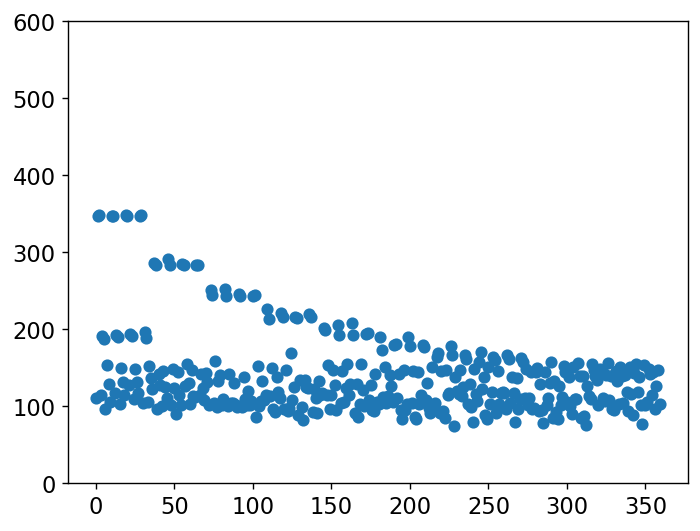

In [53]:
plt.scatter(x=[i for i in range(len(nn_grid))],y=nn_grid['RMSE'])
plt.ylim(0,600)
plt.show()

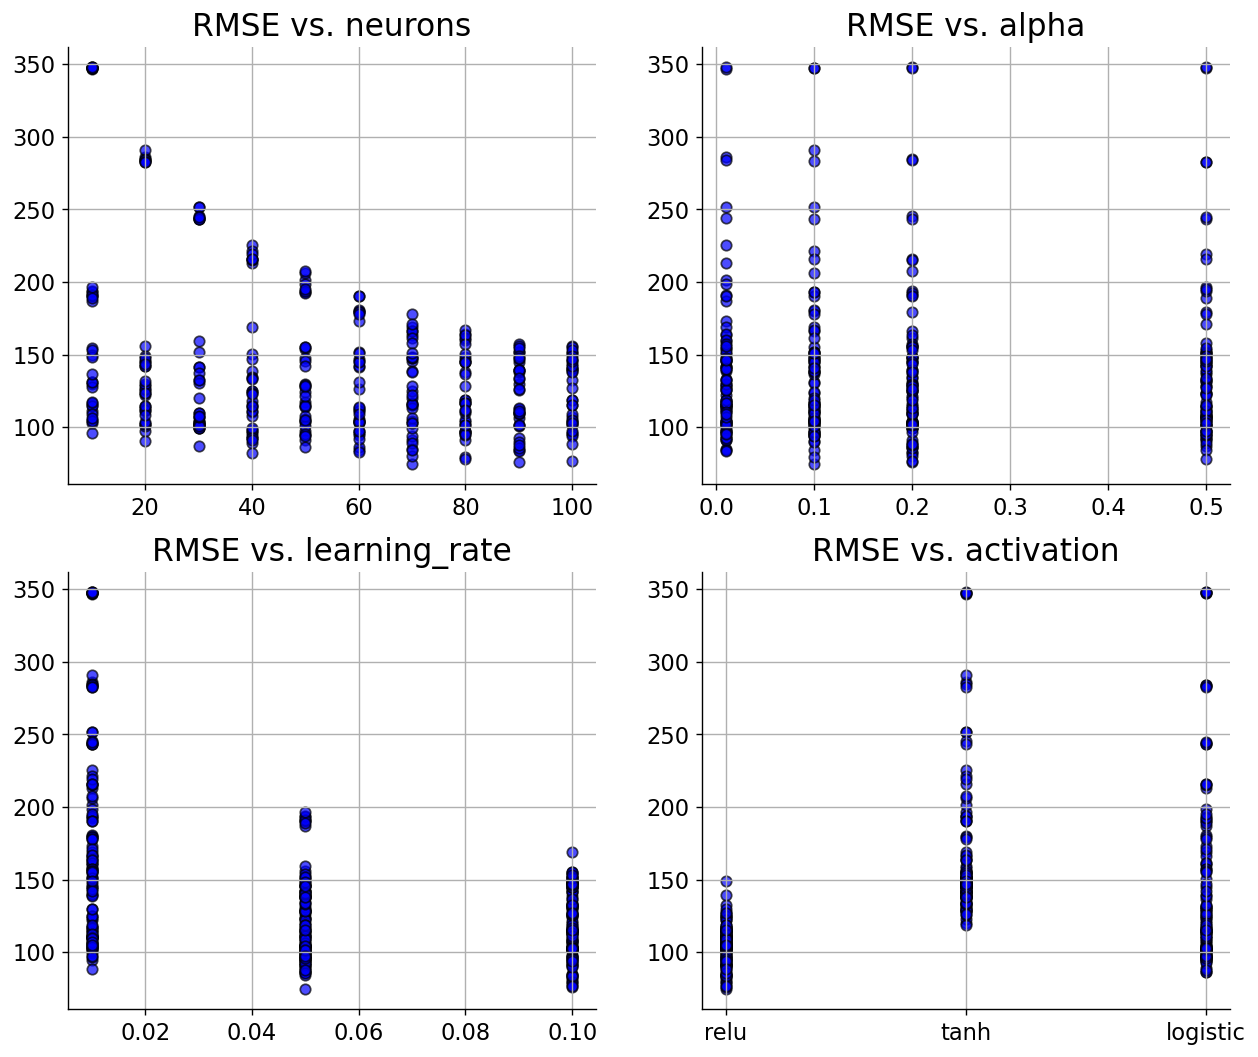

In [54]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
ax= ax.ravel()
for i,c in enumerate(nn_grid.columns[:4]):
    ax[i].scatter(nn_grid[c],nn_grid['RMSE'],edgecolor='k',alpha=0.7,c='blue')
    ax[i].set_title(f"RMSE vs. {c}")
    ax[i].grid(True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.show()

## Sample complexity

In [56]:
sample_complexity = dict.fromkeys(names,[])
frac = [0.1*i for i in range(1,11)]
for name,clf in list(zip(names,classifiers)):
    scores = []
    for f in frac:
        d_frac = d.sample(frac=f)
        X = d_frac.drop(['Campaign Period Sales','Buy'],axis=1)
        y = d_frac['Buy']
        TEST_FRAC = 0.2
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=TEST_FRAC,random_state=7406)
        X_train = StandardScaler().fit_transform(X_train)
        X_test = StandardScaler().fit_transform(X_test)
        t1 = time.time()
        clf.fit(X_train, y_train)
        t2 = time.time()
        delta_t = round((t2-t1)*1000,3)
        f1score = f1_score(y_test,clf.predict(X_test))
        scores.append(f1score)
    sample_complexity[name] = np.array(scores)
        #print(sample_complexity[name])
    print(f"Done for {name}")

Done for Logistic Regression
Done for Nearest Neighbors
Done for Linear SVM
Done for RBF SVM
Done for Decision Tree
Done for Random Forest
Done for Neural Net
Done for AdaBoost
Done for Bagging
Done for Naive Bayes
Done for QDA


In [57]:
sample_complexity=pd.DataFrame(sample_complexity)

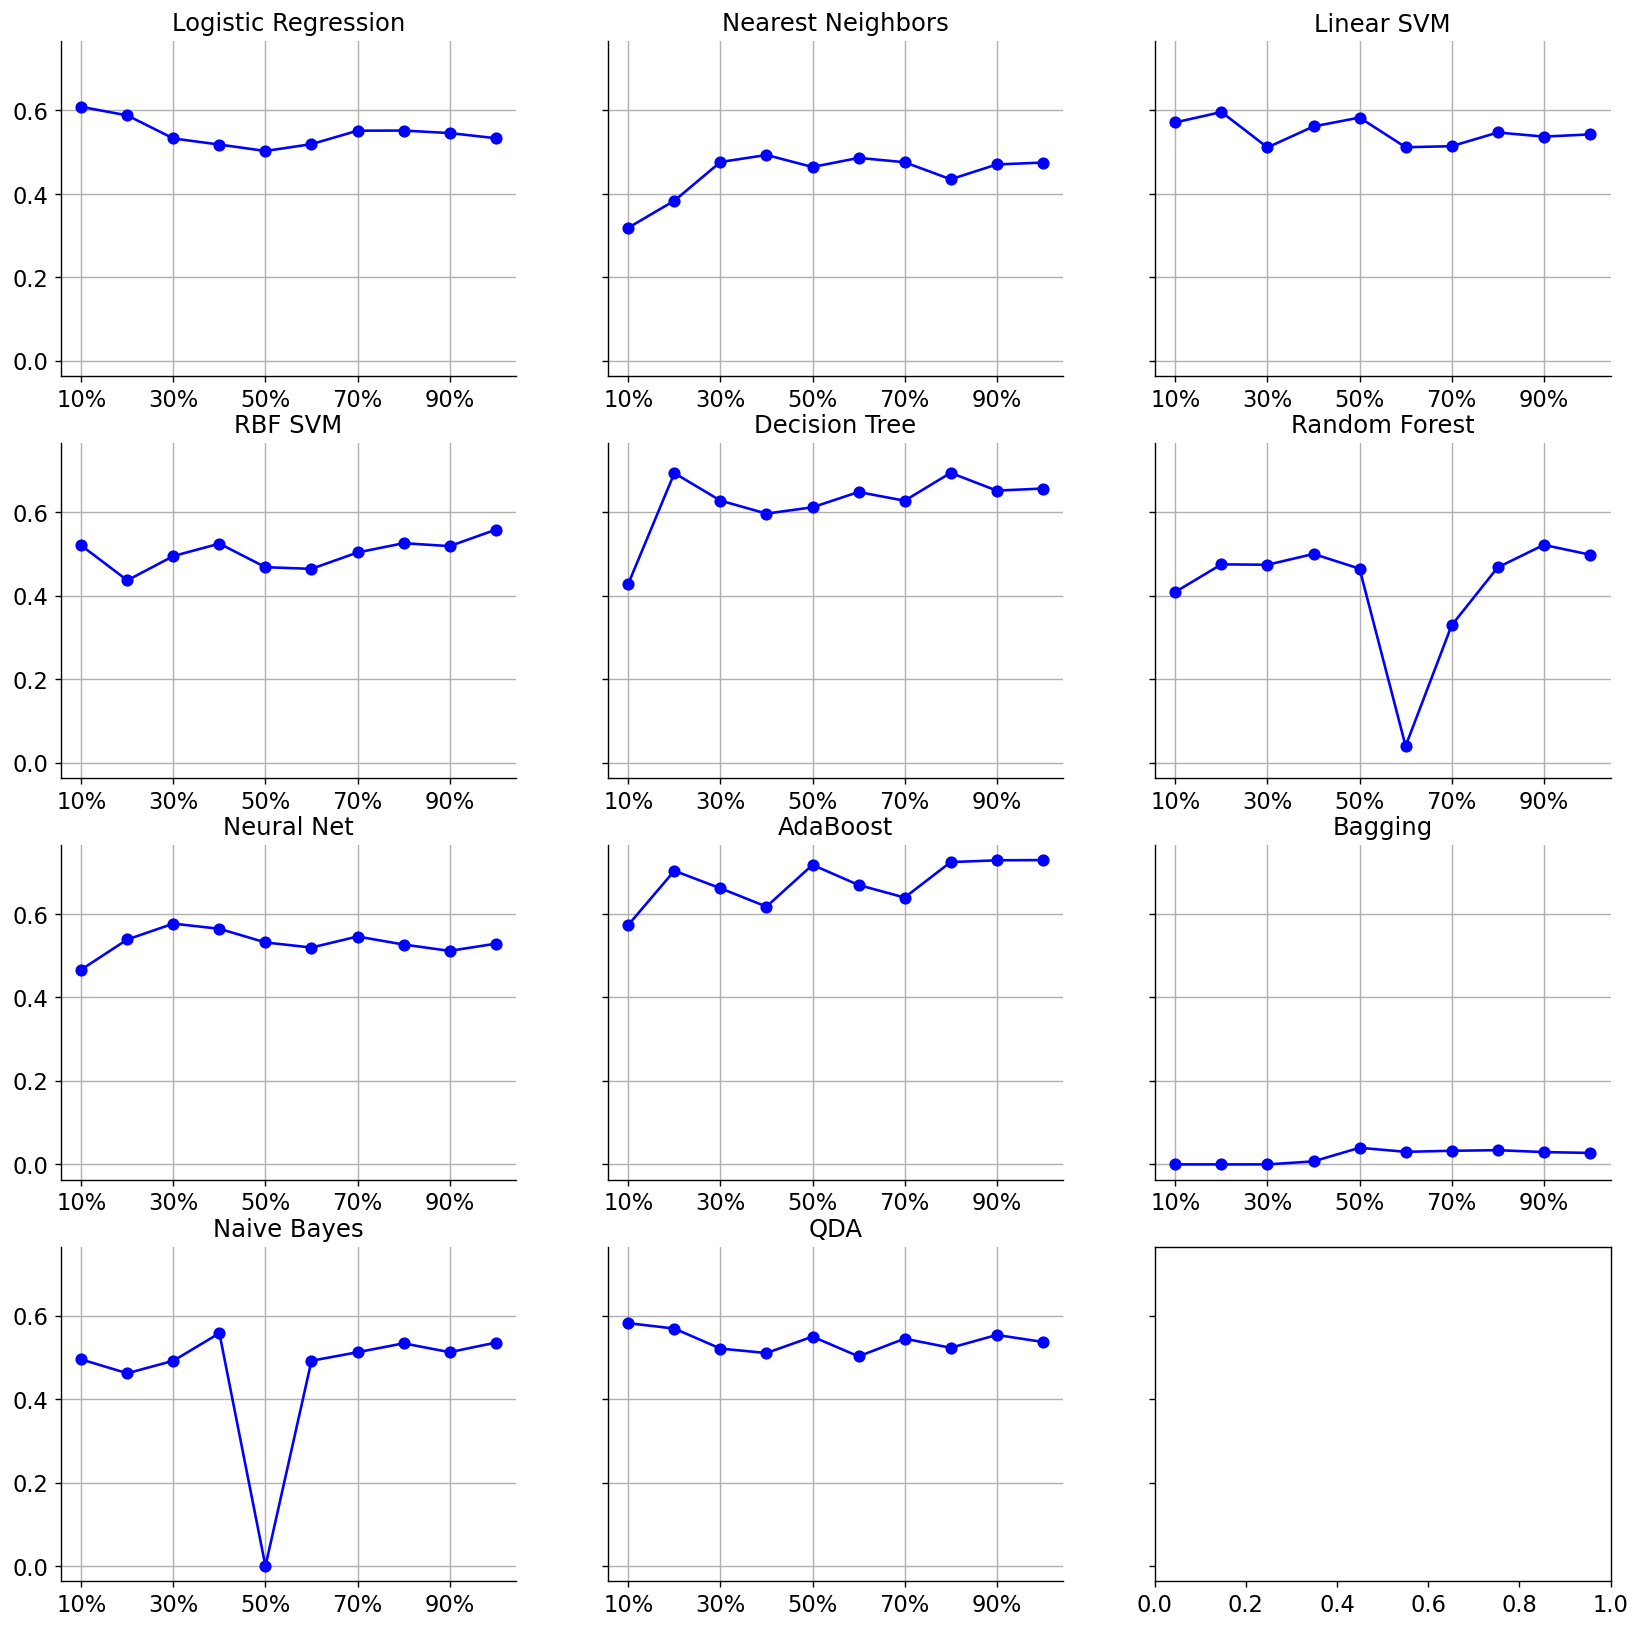

In [61]:
fig,ax = plt.subplots(4,3,figsize=(16,16),sharey=True)
ax = ax.ravel()
for i,c in enumerate(sample_complexity.columns):
    ax[i].plot([int(j) for j in range(1,11)],sample_complexity[c],marker='o',color='blue')
    ax[i].set_xticks([int(j) for j in range(1,11,2)])
    ax[i].set_xticklabels([str(10*j)+'%' for j in range(1,11,2)])
    ax[i].set_title(f"{c}",fontsize=14)
    ax[i].grid(True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.show()